In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import time

%matplotlib inline

#Import module to split the datasets
from sklearn.model_selection import train_test_split
# Import modules to evaluate the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
from sklearn.metrics import classification_report

import numpy as np
import re
import pickle 
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.datasets import load_files
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk import FreqDist
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#Textblob for Sentiment Analysis
def sentiment_blob(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

# spelling correction for given input text
def spell_correction_blob(text):
    try:
        return TextBlob(text).correct()
    except:
        return None

# cleans input text.
def text_cleaner(text):
    text = text.strip()
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = re.sub(r'^br$', ' ', text)
    text = re.sub(r'\s+br\s+',' ',text)
    text = re.sub(r'\s+[a-z]\s+', ' ',text)
    text = re.sub(r'^b\s+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]+', ' ',text)
    text = text.strip()

    return text

def plot_roc_curve(fpr, tpr):
    """
    Plots a ROC curve given the false positve rate (fpr) and 
    true postive rate (tpr) of a classifier.
    """
    # Plot ROC curve
    figure = plt.figure(figsize=(8, 4))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Guessing')
    # Customize the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

def preprocess_text(text):
    text = text_cleaner(text)
    text = lemmatize_text(text)

    return text

def get_sentiment(model,text):
    sample = [preprocess_text(text)]
    sample = vectorizer.transform(sample)
    sentiment = model.predict_proba(sample)
    
    return ('Positive', sentiment[0][1]) if sentiment[0][0] < sentiment[0][1] else ('Negative', sentiment[0][0])

class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    # print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)



In [3]:
# read data
raw_df = pd.read_csv("hotel_reviews_labeled.csv")

display(raw_df)

,hotel_name,hotel_location,review_title,review_pos,review_neg,review_date,review_country,num_reviews_by_reviewer,reviewer_name,review_rating,review_tags,label
0,Siam Eco Hostel,"13.75308373,100.53145603",“Nice hostel in a great location”,"it’s really well located, the stuff is nice an...","the breakfast could be better, but I guess it’...",2022-04-2T00:00:00,Germany,15,Karina,9.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0
1,Siam Eco Hostel,"13.75308373,100.53145603",“Relaxed hostel with great staff and great com...,The staff was superfriendly and helpful and th...,Don't expect too much from the provided breakf...,2022-03-31T00:00:00,Netherlands,4,Pleun,9.0,"Leisure trip,Group,Bed in 6-Bed Mixed Dormitor...",1.0
2,Siam Eco Hostel,"13.75308373,100.53145603",“Great hostel in convenient location”,"really nice reception staff, who let us check ...","Breakfast was a little small, but was fine",2022-03-6T00:00:00,United Kingdom,7,Maia,10.0,"Leisure trip,Group,Economy Quadruple Room with...",1.0
3,Siam Eco Hostel,"13.75308373,100.53145603",Exceptional,"Clean, nice and calm space. Breakfast was some...",No Negative,2022-03-1T00:00:00,Norway,1,Emmeli,10.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0
4,Siam Eco Hostel,"13.75308373,100.53145603",“perfect place”,everything is perfect: women in reception so n...,No Negative,2022-02-24T00:00:00,Lithuania,76,Sooofija,10.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
156088,ZEN Rooms Bukit Merah,"1.27264209,103.82767699",Poor,No Positive,No Negative,2019-06-4T00:00:00,South Korea,1,Hasung,3.3,"Business trip,Solo traveller,Superior Twin Roo...",0.0
156089,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Pleasant,The tenant lady is helpful accomodating my req...,The music at the fish pond during all night an...,2022-02-28T00:00:00,Singapore,8,Geraldine,6.0,"Leisure trip,Family with young children,Chalet...",1.0
156090,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Poor,"Place is big and roomy, near the sea and other...",Poorly maintained and dirty. No formal checkin...,2022-03-15T00:00:00,Singapore,1,Chun,3.0,"Business trip,Solo traveller,Chalet with Sea V...",0.0
156091,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Very poor,Winston was a helpful housekeeping ..even help...,A1 unit Haunted room of masterbedroom n room 3...,2022-01-24T00:00:00,Singapore,1,Nor,2.0,"Leisure trip,Family with young children,Chalet...",0.0


In [4]:
df = raw_df.copy()

In [5]:
from gensim.scripts.glove2word2vec import glove2word2vec


glove_filename='glove.6B.100d.txt'
glove_path = os.path.abspath(os.path.join(glove_filename))

word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)

<ipython-input-5-1766ae10d256>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


(400000, 100)

In [6]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#Show a word embedding
print('King: ',model.get_vector('king'))

result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

print('Most similar word to King + Woman: ', result)

King:  [-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  0.16483  -

In [7]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#Show a word embedding
print('contented: ',model.get_vector('contented'))

result = model.most_similar(positive=['contented'], topn=10)

print('Most similar word to contented: ', result)

contented:  [-0.19368    0.11013    0.37022    0.39105   -0.37537    0.77581
  0.16254    0.31292   -0.014729  -0.27041   -0.79457    0.43912
  0.27794   -0.63579    0.25541    0.039719   0.15351    0.16245
  0.27322   -0.092108   0.36882    0.042217  -0.49091   -0.44934
  0.040682  -0.029732  -0.66679    0.55124    0.23009   -0.029307
  0.038782   0.2533    -0.31765   -1.0986     0.25827    0.060058
 -0.30451    0.12792   -0.11197   -0.36817    0.13846   -0.20171
  0.24504    0.24886   -0.33077   -0.096547   0.58461    0.55337
 -0.13092   -0.12446   -0.61951   -0.66229    0.34086   -0.027619
 -0.1001     0.48788    0.1315    -0.22223   -0.59043   -0.050806
  0.27589   -0.19781   -0.54821   -0.24357   -0.029975   0.44395
  1.0692     0.15471   -0.2914    -0.29369    0.49637    0.061752
  0.20342   -0.41644    0.018974   0.15103    0.038664  -1.0205
  0.42666   -0.49526   -0.25212    0.0753     0.29201    1.4389
 -0.28757    0.10059    0.052696   0.31721   -1.095     -0.20183
  0.063725

In [8]:
df_title = df.groupby(['review_title']).max().reset_index()

df_title.dropna(inplace=True)
df_title['review_title'] = df_title['review_title'].apply(text_cleaner) # cleans data

df_title = df_title.groupby('review_title').mean().reset_index() # cleans data

df_title['blob'] = df_title['review_title'].apply(sentiment_blob) # apply TextBlob sentiment analysis
df_title['polarity'] = df_title['blob'].apply(lambda x: x[0]) # extract polarity score from blob column
df_title['subjectivity'] = df_title['blob'].apply(lambda x: x[1]) # extract subjectivity score from blob coumn
df_title['word_count'] = df_title['review_title'].apply(lambda x: len(x.strip().split(' ')))

df_title['review_title'] = df_title['review_title'].apply(lambda x: None if len(x) <2 else x) # reviews with a single space
df_title.dropna(inplace=True)

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

df_title['review_title'] = df_title['review_title'].apply(lemmatize_text)
df_title['label'] = df_title['label'].apply(lambda x: int(x))

df_title.dropna(inplace=True)

df_neg = df_title[(df_title['subjectivity'] > 0.5) & (df_title['label'] == 0)]
df_pos = df_title[(df_title['subjectivity'] > 0.5) & (df_title['label'] == 1)]

print(len(df_neg))
print(len(df_pos))

# Downsample positive
df_pos = df_pos.sample(len(df_neg))

df_data = pd.concat([df_neg, df_pos])
df_data.rename(columns={'label':'y_true'}, inplace=True)

df_data['y_true'] = df_data['y_true'].apply(lambda x: int(x))

X, y = df_data['review_title'].reset_index(drop=True), df_data['y_true'].reset_index(drop=True)

print('Total number of rows: ', df_data.shape[0])
print('Total number of positive reviews: ', y.sum())
print('Percentage of positive reivews:', y.sum()/df_data.shape[0])


<ipython-input-8-44e629ac2f30>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  df_title = df.groupby(['review_title']).max().reset_index()


1736
20775
Total number of rows:  3472
Total number of positive reviews:  1736
Percentage of positive reivews: 0.5


In [9]:
y.unique()

array([0, 1], dtype=int64)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.288, random_state = 1)

print(len(X_test))

1000


In [11]:
vectorizer = Word2VecVectorizer(model)
# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(X_train)
Ytrain = y_train
# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
Ytest = y_test

Loading in word vectors...
Finished loading in word vectors


In [12]:
print(Xtrain.shape,Xtest.shape)

(2472, 100) (1000, 100)


train score: 0.9033171521035599
test score: 0.87


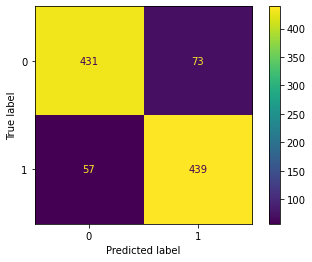

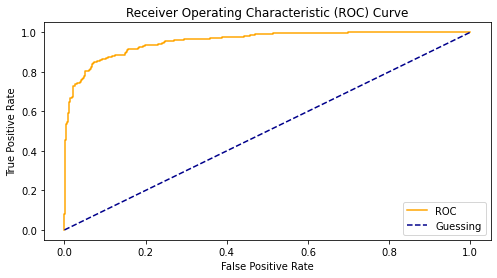

              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87       504
    Positive       0.86      0.89      0.87       496

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000

Total time to classify 1000 records: 0.0009999275207519531 seconds
Time to classify each record: 9.999275207519531e-07 seconds


In [13]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(Xtrain, Ytrain)


print("train score:", lr_model.score(Xtrain, Ytrain))
print("test score:", lr_model.score(Xtest, Ytest))


y_preds = lr_model.predict(Xtest)

ConfusionMatrixDisplay.from_predictions(Ytest, y_preds)

# Make predictions with probabilities
y_probs = lr_model.predict_proba(Xtest)

y_probs_positive = y_probs[:, 1]
# Caculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(Ytest, y_probs_positive)
# Create a function for plotting ROC curves

plot_roc_curve(fpr, tpr)

target_names = ['Negative', 'Positive']

print(classification_report(Ytest, y_preds, target_names=target_names))

start = time.time()

lr_model.predict(Xtest)

end = time.time()

print(f"Total time to classify {len(Xtest)} records: {end - start} seconds")
print(f"Time to classify each record: {((end - start)/len(Xtest))} seconds")

In [14]:
unique_terms = set()
df_data['review_title'].str.lower().str.split().apply(unique_terms.update)


20       None
24       None
39       None
47       None
60       None
         ... 
10328    None
1432     None
13976    None
5372     None
472      None
Name: review_title, Length: 3472, dtype: object

In [15]:
word = 'contented'

print(f"'{word}' in dictionary: {word in unique_terms}")

print(get_sentiment(lr_model, word),'\n')

word = 'detriment'

print(f"'{word}' in dictionary: {word in unique_terms}")

print(get_sentiment(lr_model, word))

'contented' in dictionary: False
('Positive', 0.9963111599356386) 

'detriment' in dictionary: False
('Negative', 0.991958935986971)


In [16]:
def get_pred(text):
    sample = [preprocess_text(text)]
    sample = vectorizer.transform(sample)
    sentiment = lr_model.predict_proba(sample)
    
    return 1 if sentiment[0][0] < sentiment[0][1] else 0


sid = SentimentIntensityAnalyzer()

def get_ensemble_sentiment(text):
    vader_sentiment = 1 if sid.polarity_scores(text)['pos'] > sid.polarity_scores(text)['neg'] else 0
    textblob_sentiment = 1 if TextBlob(text).sentiment[0] > 0 else 0
    ml_sentiment = get_pred(text)
    sum = vader_sentiment + textblob_sentiment + ml_sentiment

    return 1 if sum >= 2 else 0

get_ensemble_sentiment('best hotel ever')


1

In [20]:
filename = 'logreg_model.pkl'
pickle.dump(lr_model, open(filename, 'wb'))

In [17]:
df_pred = raw_df.copy().dropna().reset_index(drop=True)

display(df_pred)

,hotel_name,hotel_location,review_title,review_pos,review_neg,review_date,review_country,num_reviews_by_reviewer,reviewer_name,review_rating,review_tags,label
0,Siam Eco Hostel,"13.75308373,100.53145603",“Nice hostel in a great location”,"it’s really well located, the stuff is nice an...","the breakfast could be better, but I guess it’...",2022-04-2T00:00:00,Germany,15,Karina,9.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0
1,Siam Eco Hostel,"13.75308373,100.53145603",“Relaxed hostel with great staff and great com...,The staff was superfriendly and helpful and th...,Don't expect too much from the provided breakf...,2022-03-31T00:00:00,Netherlands,4,Pleun,9.0,"Leisure trip,Group,Bed in 6-Bed Mixed Dormitor...",1.0
2,Siam Eco Hostel,"13.75308373,100.53145603",“Great hostel in convenient location”,"really nice reception staff, who let us check ...","Breakfast was a little small, but was fine",2022-03-6T00:00:00,United Kingdom,7,Maia,10.0,"Leisure trip,Group,Economy Quadruple Room with...",1.0
3,Siam Eco Hostel,"13.75308373,100.53145603",Exceptional,"Clean, nice and calm space. Breakfast was some...",No Negative,2022-03-1T00:00:00,Norway,1,Emmeli,10.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0
4,Siam Eco Hostel,"13.75308373,100.53145603",“perfect place”,everything is perfect: women in reception so n...,No Negative,2022-02-24T00:00:00,Lithuania,76,Sooofija,10.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
142291,ZEN Rooms Bukit Merah,"1.27264209,103.82767699",Poor,No Positive,No Negative,2019-06-4T00:00:00,South Korea,1,Hasung,3.3,"Business trip,Solo traveller,Superior Twin Roo...",0.0
142292,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Pleasant,The tenant lady is helpful accomodating my req...,The music at the fish pond during all night an...,2022-02-28T00:00:00,Singapore,8,Geraldine,6.0,"Leisure trip,Family with young children,Chalet...",1.0
142293,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Poor,"Place is big and roomy, near the sea and other...",Poorly maintained and dirty. No formal checkin...,2022-03-15T00:00:00,Singapore,1,Chun,3.0,"Business trip,Solo traveller,Chalet with Sea V...",0.0
142294,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Very poor,Winston was a helpful housekeeping ..even help...,A1 unit Haunted room of masterbedroom n room 3...,2022-01-24T00:00:00,Singapore,1,Nor,2.0,"Leisure trip,Family with young children,Chalet...",0.0


In [18]:
df_test = df_data.sample(int(0.2881*len(df_data)))
df_test['pred'] = df_test['review_title'].apply(get_ensemble_sentiment)

              precision    recall  f1-score   support

    Negative       0.98      0.95      0.97       507
    Positive       0.95      0.98      0.97       493

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

Total time to classify 1000 records: 0.6677870750427246 seconds
Time to classify each record: 0.0006677870750427246 seconds


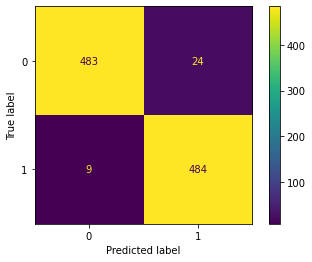

In [19]:
y_preds = df_test['pred']
y_test = df_test['y_true']
accuracy_score(y_test, y_preds)



ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

target_names = ['Negative', 'Positive']

print(classification_report(y_test, y_preds, target_names=target_names))

start = time.time()

df_test['pred'] = df_test['review_title'].apply(get_ensemble_sentiment)

end = time.time()

print(f"Total time to classify {len(X_test)} records: {end - start} seconds")
print(f"Time to classify each record: {((end - start)/len(X_test))} seconds")